In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import rdkit
import mols2grid
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors, rdCoordGen
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
%matplotlib inline 

# ML models
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch.optim.lr_scheduler import StepLR
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
from torch_geometric.utils import to_networkx
from torch_geometric.utils import from_smiles
from torch_geometric.nn import AttentiveFP
import torch.nn.functional as F
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, mean_absolute_error, mean_squared_error

In [2]:
# Set the seed value
random_seed = 50

# Ensure reproducibility across PyTorch (CPU & GPU)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

# Ensure reproducibility for NumPy
np.random.seed(random_seed)

# Ensure deterministic behavior in PyTorch operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
df = pd.read_csv("tg_inliers.csv")
df.shape

(6815, 3)

In [4]:
df

,smiles,tg,Outlier
0,*CC(*)C,-3.0,1
1,*CC(*)CC,-24.1,1
2,*CC(*)CCC,-37.0,1
3,*CC(*)C(C)C,60.0,1
4,*CC(*)CCCC,-50.0,1
...,...,...,...
6810,*CC(*)(F)C(=O)OCCC,62.0,1
6811,*CC(F)(F)C1(F)C(*)CC(O)(C(F)(F)F)C1(F)F,152.0,1
6812,*CC(F)(F)C1(F)CC(CC(O)(C(F)(F)F)C(F)(F)F)CC1*,98.0,1
6813,*CC(F)(F)C1(F)CC(C(O)(C(F)(F)F)C(F)(F)F)CC1*,118.0,1


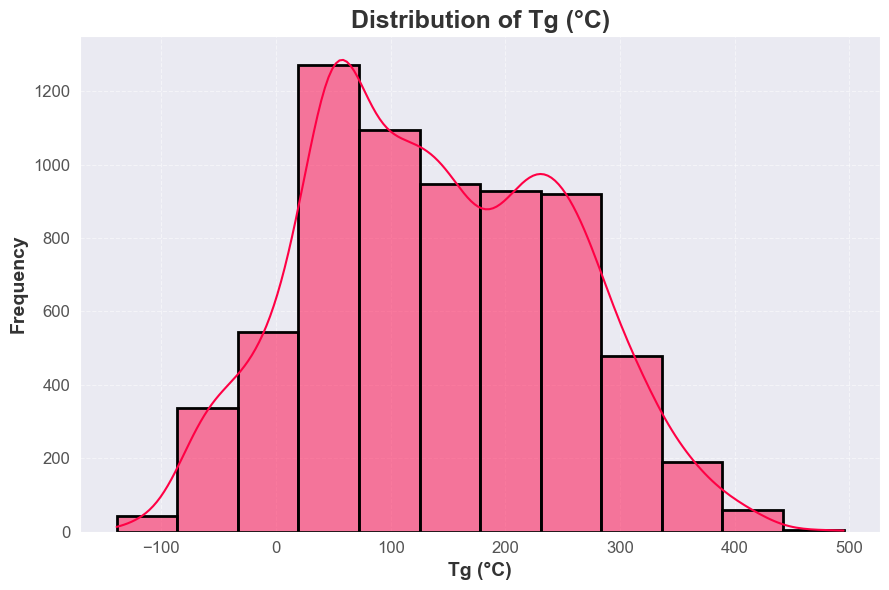

In [5]:
# Choose a style for the plot
sns.set_style('darkgrid')
sns.set_palette("crest")

# Set a font
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 10

# Create a figure
plt.figure(figsize=(9, 6))

# Visualize the distribution
sns.histplot(data=df, x='tg', color='#ff0044', edgecolor='black', bins=12, kde=True, linewidth=2)

# Add titles and labels
plt.title('Distribution of Tg (°C)', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Tg (°C)', fontsize=14, fontweight='bold', color='#333333')
plt.ylabel('Frequency', fontsize=14, fontweight='bold', color='#333333')

# Improve the grid and ticks
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=12, color='#555555')
plt.yticks(fontsize=12, color='#555555')

# Show the plot
plt.tight_layout()
plt.show()

In [6]:
# Visualising Chemicals
smiles_list = df['smiles'].to_list()
chems = [rdkit.Chem.MolFromSmiles(x) for x in smiles_list]
mols2grid.display(chems)

MolGridWidget()

In [7]:
# Initialize an empty list to store the graphs
graph_list = []

# Iterate over each SMILES string in the DataFrame
for i, smile in enumerate(df['smiles']):
    # Generate the graph from the SMILES string
    g = from_smiles(smile)
    
    # Ensure that the node features are in float format
    g.x = g.x.float()

    # Create a tensor for the target value and reshape it to match expected dimensions
    y = torch.tensor(df['tg'][i], dtype=torch.float).view(1, -1)
    
    # Assign the target tensor to the graph
    g.y = y
    
    # Append the processed graph to the list
    graph_list.append(g)

In [8]:
graph_list[3]

Data(x=[7, 9], edge_index=[2, 12], edge_attr=[12, 3], smiles='*CC(*)C(C)C', y=[1, 1])

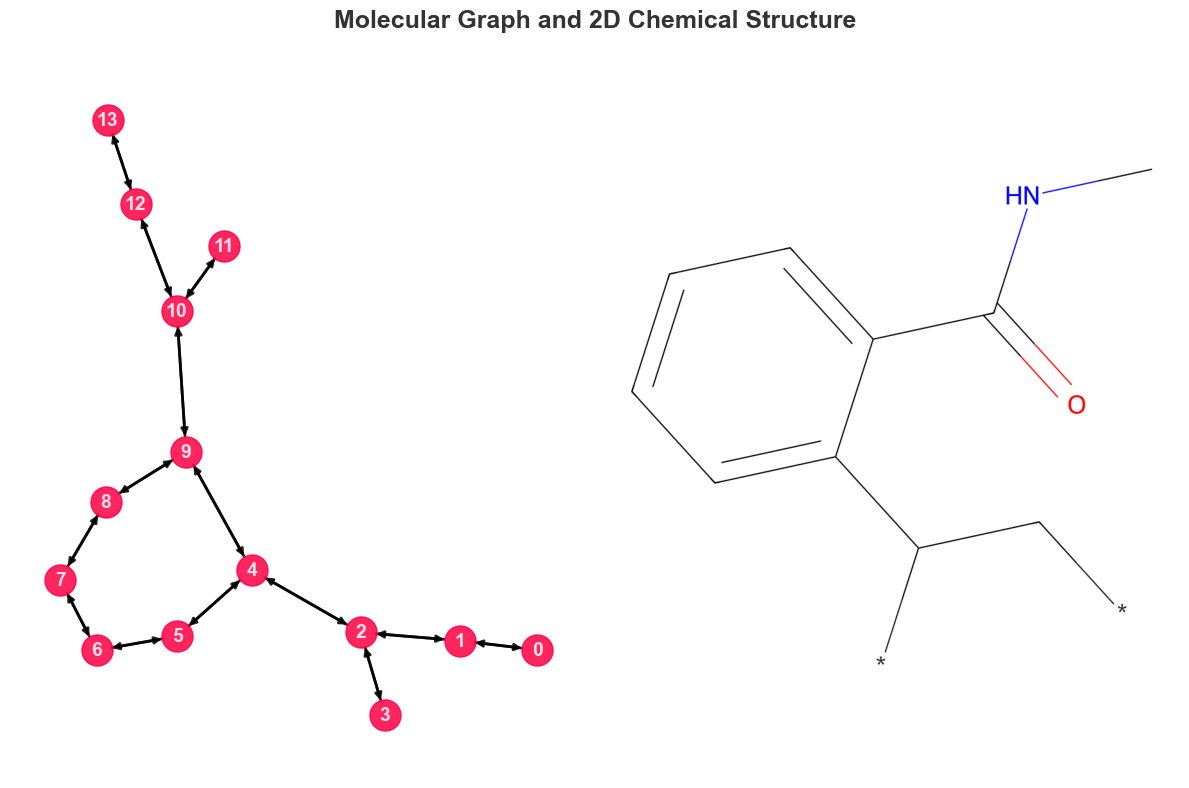

In [9]:
# Function to plot the molecular graph
def plot_graph(g, ax):
    # Convert the graph to a NetworkX graph for plotting
    nx_g = to_networkx(g)
    
    # Define a color palette
    node_color = '#ff0044'  # Light green for nodes
    edge_color = 'black'  # Dark gray for edges
    
    # Customize layout (spring layout is often good for molecular graphs)
    pos = nx.spring_layout(nx_g, seed=53)
    
    # Draw the graph with enhanced aesthetics
    nx.draw(nx_g, ax=ax, pos=pos, with_labels=True, node_size=500, font_size=14, 
            font_color='white', font_weight='bold', node_color=node_color, 
            edge_color=edge_color, width=2, alpha=0.85)

    # Hide axis
    ax.axis('off') 

# Function to plot the 2D chemical structure using RDKit
def plot_2d_structure(smiles, ax):
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol, size=(900, 900))
    
    # Set background color to something subtle and add border around the molecule
    ax.imshow(img)
    
    # Hide axis
    ax.axis('off')

# Create a single figure with two subplots (one row, two columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 8))  # Larger figure size

# Plot the graph and its 2D chemical structure
g = graph_list[53]  
smiles = df['smiles'][53]

plot_graph(g, axes[0])  # Left side: Plot the molecular graph
plot_2d_structure(smiles, axes[1])  # Right side: Plot the 2D chemical structure

# Add titles for the whole figure and subplots
fig.suptitle('Molecular Graph and 2D Chemical Structure', fontsize=18, fontweight='bold', color='#333333')

# Adjust layout and show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Add some space for the title
plt.show()

In [10]:
# Define the ratio for splitting the dataset (80% for training, 20% for validation)
train_ratio = 0.80

# Calculate the total number of samples in the dataset
dataset_size = len(graph_list)

# Calculate the number of samples for the training and validation sets
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Set a random seed for reproducibility
random_seed = 66
generator = torch.Generator().manual_seed(random_seed)

# Split the dataset into training and validation subsets
train_dataset, val_dataset = random_split(graph_list, [train_size, val_size], generator=generator)

In [11]:
# Create the DataLoaders for the train and val sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [12]:
# Set up the device (GPU if available, otherwise CPU) and initialize the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the AttentiveFP model with specified parameters and move it to the appropriate device
model = AttentiveFP(in_channels=9, hidden_channels=64, out_channels=1,
                    edge_dim=3, num_layers=4, num_timesteps=2,
                    dropout=0.0).to(device)

# Set up the NAdam optimizer with learning rate and weight decay for regularization
optimizer = torch.optim.NAdam(model.parameters(), lr=0.0008, weight_decay=0.0)

# Set up a Scheduler
scheduler = StepLR(optimizer, step_size=20, gamma=0.7)

In [13]:
def train():
    # Initialize total loss and total samples counters
    total_loss = total_samples = 0
    
    # Iterate through the training dataset
    for data in train_loader:
        # Move data to the appropriate device (GPU or CPU)
        data = data.to(device)
        
        # Zero out gradients from the previous step
        optimizer.zero_grad()
        
        # Forward pass through the model to get predictions
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        
        # Calculate Mean Squared Error loss between predicted and actual values
        loss = F.mse_loss(out, data.y)
        
        # Backpropagate the loss to compute gradients
        loss.backward()
        
        # Update model parameters based on computed gradients
        optimizer.step()
        
        # Accumulate the loss weighted by the number of graphs in the batch
        total_loss += float(loss) * data.num_graphs
        
        # Accumulate the total number of graphs processed
        total_samples += data.num_graphs
    
    # Return the root mean squared error (RMSE) over the entire training set
    return np.sqrt(total_loss / total_samples)

In [14]:
@torch.no_grad()  # Disable gradient calculation for inference
def val(loader):
    mse = []  # List to store MSE for each batch
    model.eval()  # Set model to evaluation mode
    
    for data in loader:
        data = data.to(device)  # Move data to the device
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)  # Model forward pass
        l = F.mse_loss(out, data.y, reduction='none').cpu()  # Calculate MSE loss for the batch
        mse.append(l)  # Append loss to the list
    
    # Calculate and return RMSE (square root of the mean of the MSEs)
    rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    return rmse

In [15]:
# Initialize lists to store training and val scores (RMSE values)
score_train = []
score_val = []

# Set the number of epochs for training
epochs = 110

# Reset the model parameters at the beginning of training
model.reset_parameters()

# Loop over each epoch for training
for epoch in range(epochs):
    
    # Train the model and get the training RMSE
    train_rmse = train()

    # Adjust learning rate
    scheduler.step()

    # Validate the model and get the val RMSE
    val_rmse = val(val_loader)

    # Append the training RMSE and val RMSE to their respective lists
    score_train.append(train_rmse)
    score_val.append(val_rmse)

    # Print the progress of the training process (epoch number, train loss, val loss)
    print(f'Epoch: {epoch+1}/{epochs} | Train Loss: {train_rmse:.4f}, '
          f'Validation Loss: {val_rmse:.4f}')

Epoch: 1/110 | Train Loss: 107.7950, Validation Loss: 92.7719
Epoch: 2/110 | Train Loss: 93.2700, Validation Loss: 87.4025
Epoch: 3/110 | Train Loss: 77.3858, Validation Loss: 68.5990
Epoch: 4/110 | Train Loss: 69.7156, Validation Loss: 71.8824
Epoch: 5/110 | Train Loss: 67.4003, Validation Loss: 63.9068
Epoch: 6/110 | Train Loss: 66.5177, Validation Loss: 70.8326
Epoch: 7/110 | Train Loss: 65.6599, Validation Loss: 61.8190
Epoch: 8/110 | Train Loss: 64.4959, Validation Loss: 61.5858
Epoch: 9/110 | Train Loss: 64.0585, Validation Loss: 62.4833
Epoch: 10/110 | Train Loss: 63.5560, Validation Loss: 61.1526
Epoch: 11/110 | Train Loss: 62.8446, Validation Loss: 73.7625
Epoch: 12/110 | Train Loss: 61.3961, Validation Loss: 75.6464
Epoch: 13/110 | Train Loss: 59.6580, Validation Loss: 55.4281
Epoch: 14/110 | Train Loss: 56.4704, Validation Loss: 52.6940
Epoch: 15/110 | Train Loss: 59.5149, Validation Loss: 56.8237
Epoch: 16/110 | Train Loss: 57.3176, Validation Loss: 60.5186
Epoch: 17/110 | 

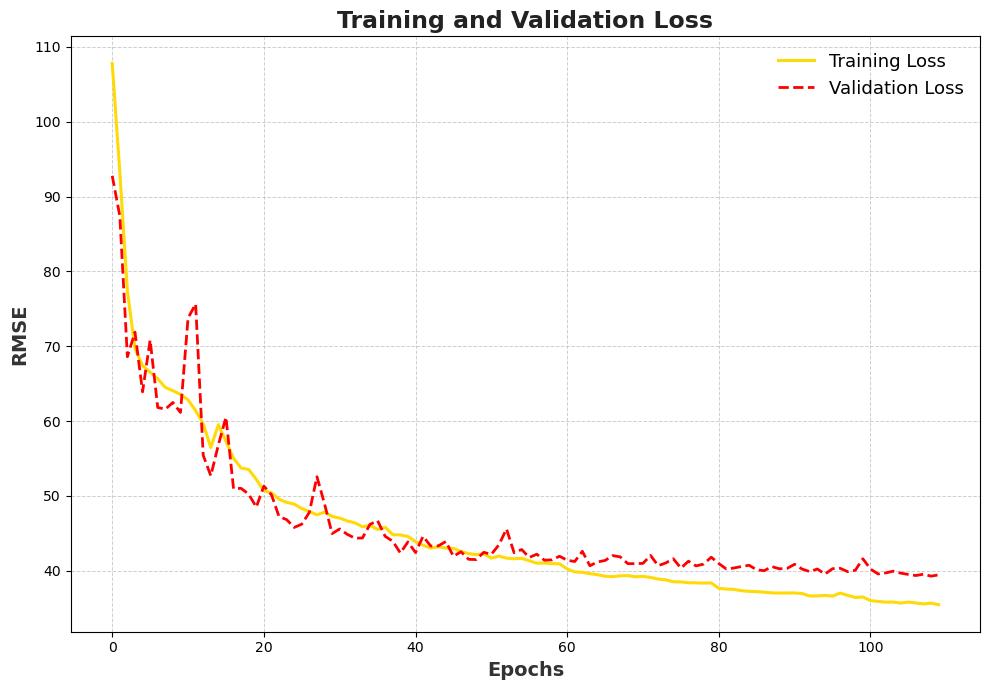

In [16]:
#Choose a style for the plot
plt.style.use("default")

# Create figure
plt.figure(figsize=(10, 7))

# Plot training and validation losses with improved styling
plt.plot(range(epochs), score_train, label='Training Loss', 
         color='#ffda06', linestyle='-', linewidth=2.2, alpha=1)

plt.plot(range(epochs), score_val, label='Validation Loss', 
         color='red', linestyle='--', linewidth=2, alpha=1)

# Labels and title with a bold but clean look
plt.xlabel('Epochs', fontsize=14, fontweight='bold', color='#333333')
plt.ylabel('RMSE', fontsize=14, fontweight='bold', color='#333333')
plt.title('Training and Validation Loss', fontsize=17, fontweight='bold', color='#222222')

# Improve grid visibility but keep it subtle
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)

# Improve legend (slightly larger, no border)
plt.legend(loc='upper right', fontsize=13, frameon=False)

# Adjust layout for a clean look
plt.tight_layout()
plt.show()

In [17]:
@torch.no_grad()  # Disable gradient computation for evaluation
def eval(loader):
    output = []  # Store model predictions and true values
    smi = []  # Store SMILES strings
    model.eval()  # Set model to evaluation mode
    
    for data in loader:
        data = data.to(device)  # Move data to the correct device (GPU/CPU)
        
        # Get model predictions
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        
        # Concatenate predictions and actual values
        concatenated_data = torch.cat((out, data.y.view(-1, 1)), dim=1)
        output.append(concatenated_data)  # Append to output list
        
        smi.append(data.smiles)  # Append SMILES strings
    
    # Stack the predictions and actual values
    stacked_output = torch.cat(output, dim=0)
    
    # Move to CPU and convert to NumPy
    stacked_output = stacked_output.cpu().numpy()
    
    # Concatenate all SMILES strings
    stacked_smiles = np.concatenate(smi)
    
    # Combine predictions, actual values, and SMILES into a DataFrame
    results = pd.concat([pd.DataFrame(stacked_output, columns=['pred', 'actual']), 
                         pd.DataFrame(stacked_smiles, columns=['smiles'])], axis=1)
    
    return results

In [18]:
val_res = eval(val_loader)

In [19]:
def evaluate_preds(y_true, y_preds):
    # Calculate metrics
    metrics = {"R2": r2_score(y_true, y_preds),
               "RMSE": np.sqrt(mean_squared_error(y_true, y_preds)),
               "MAE": mean_absolute_error(y_true, y_preds)}

    # Print the metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")

    # Return rounded metrics
    return {metric: round(value, 3) for metric, value in metrics.items()}

In [20]:
evaluate_preds(val_res['actual'], val_res['pred']);

R2: 0.874
RMSE: 39.457
MAE: 28.257


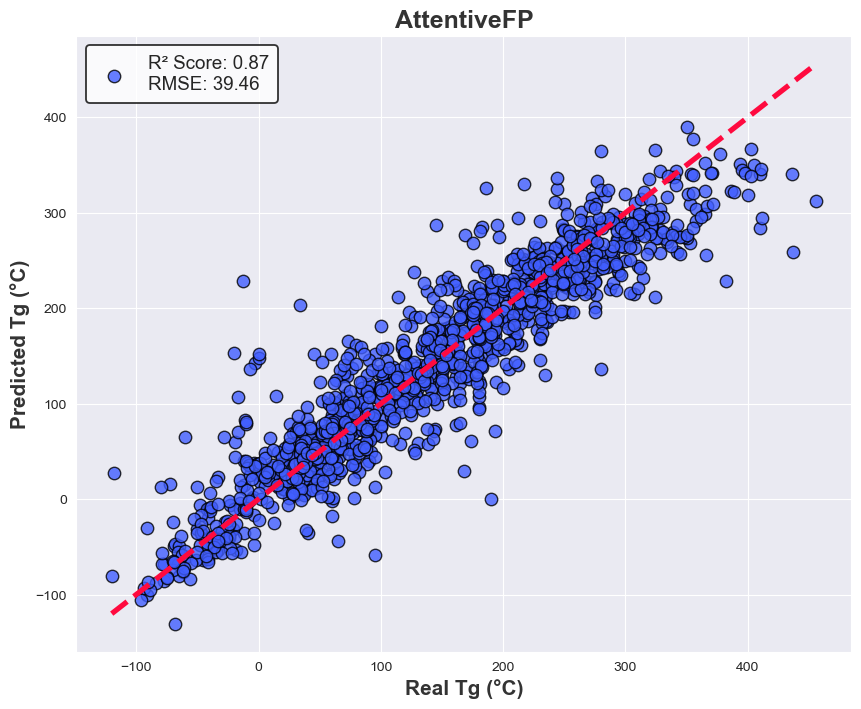

In [21]:
# Compute R² score and RMSE
r2 = r2_score(val_res['actual'], val_res['pred'])
rmse = np.sqrt(mean_squared_error(val_res['actual'], val_res['pred']))

# Choose a style for the plot
sns.set_style('darkgrid')  # Dark grid background for the plot
sns.set_palette("crest")  # Set the color palette for the plot

# Set figure size
plt.figure(figsize=(10, 8))

# Scatter plot: Actual vs Predicted values
plt.scatter(val_res['actual'], val_res['pred'], color='#415eff', alpha=0.8, edgecolors='black', s=80)

# Plot the line of perfect prediction (45-degree line)
plt.plot([min(val_res['actual']), max(val_res['actual'])], 
         [min(val_res['actual']), max(val_res['actual'])], 
         color='#ff0a3f', linestyle='--', lw=3.8, label="Perfect Fit (y=x)")  

# Create legend text
legend_text = f'R² Score: {r2:.2f}\nRMSE: {rmse:.2f}'

# Add a professional-looking legend in the **top-left corner**
legend = plt.legend([legend_text], loc="upper left", fontsize=13.5, 
                    frameon=True, edgecolor="black", facecolor="white", 
                    borderpad=0.5)

# Increase border thickness
legend.get_frame().set_linewidth(1.3)

# Title and labels
plt.title('AttentiveFP', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Real Tg (°C)', fontsize=15, fontweight='bold', color='#333333')
plt.ylabel('Predicted Tg (°C)', fontsize=15, fontweight='bold', color='#333333')

# Display grid and plot
plt.grid(True)
plt.show()

In [22]:
df_test = pd.read_csv("tg-exp.csv")
df_test

,smiles,tg exp
0,*C/C=C\C*,-102.15
1,*N[Si](*)(C)C,-82.15
2,*CC=C(C*)CCCC,-81.15
3,*CC*,-78.15
4,*CC=C(C*)CCC,-77.15
...,...,...
102,*c1ccc(Oc2ccc(-c3nc4ccccc4c(-c4ccc(Oc5ccc(-c6c...,344.85
103,*Nc1ccc(C2(c3ccc(NC(=O)c4ccc(C5(c6ccc(C(*)=O)c...,384.85
104,*Oc1ccc(-n2c(=O)c3cc4c(=O)n(-c5ccc(*)cc5)c(=O)...,398.85
105,*C(=O)Nc1ccc(C2(c3ccc(NC(=O)c4ccc(C5(c6ccc(*)c...,399.85


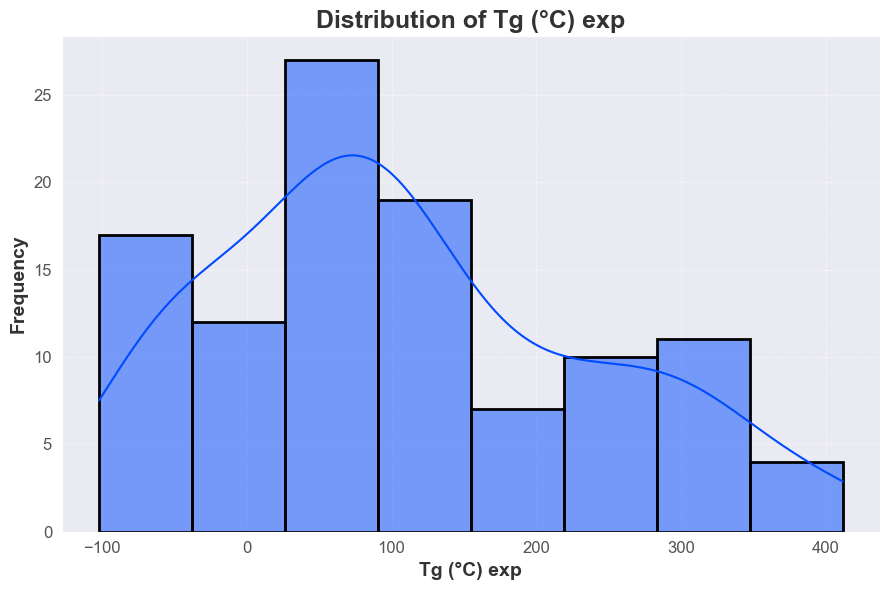

In [23]:
# Choose a style for the plot
sns.set_style('darkgrid')
sns.set_palette("crest")

# Set a font
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 10

# Create a figure
plt.figure(figsize=(9, 6))

# Visualize the distribution
sns.histplot(data=df_test, x='tg exp', color='#004aff', edgecolor='black', bins=8, kde=True, linewidth=2)

# Add titles and labels
plt.title('Distribution of Tg (°C) exp', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Tg (°C) exp', fontsize=14, fontweight='bold', color='#333333')
plt.ylabel('Frequency', fontsize=14, fontweight='bold', color='#333333')

# Improve the grid and ticks
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=12, color='#555555')
plt.yticks(fontsize=12, color='#555555')

# Show the plot
plt.tight_layout()
plt.show();

In [24]:
# Initialize an empty list to store the graphs
graph_list_test = []

# Iterate over each SMILES string in the DataFrame
for i, smile in enumerate(df_test['smiles']):
    # Generate the graph from the SMILES string
    g = from_smiles(smile)
    
    # Ensure that the node features are in float format
    g.x = g.x.float()

    # Create a tensor for the target value and reshape it to match expected dimensions
    y = torch.tensor(df_test['tg exp'][i], dtype=torch.float).view(1, -1)
    
    # Assign the target tensor to the graph
    g.y = y
    
    # Append the processed graph to the list
    graph_list_test.append(g)

In [25]:
test_loader = DataLoader(graph_list_test, batch_size=32)

In [26]:
test_res = eval(test_loader)

In [27]:
evaluate_preds(test_res['actual'], test_res['pred']);

R2: 0.806
RMSE: 56.687
MAE: 41.423
